### Predict Sahel rainfall with LSTM models - with and without various Attention mechanisms

In this project we work with **C**limate **I**ndex **C**ollection based on **Mo**del **D**ata (CICMoD) data set (https://github.com/MarcoLandtHayen/climate_index_collection). 

Here, we will try to **predict future** Sahel rainfall (lead time 1 month) from current and past information (t<=0) of all **CESM** input features including PREC_SAHEL and months as additional input features with **LSTM encoder/decoder** models.

- Set up simple LSTM model, check baseline performance.
- Add input and/or temporal attention layers.

In [186]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from matplotlib import pyplot as plt
from json import dump, load
from pathlib import Path

from keras import backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    LSTM, Dense, RepeatVector, Input, BatchNormalization,
    multiply, concatenate, Flatten, Activation, dot, Lambda
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

### Import additional functions:
from predict_sahel_rainfall.plot import bar_color
from predict_sahel_rainfall.preprocessing import prepare_inputs_and_target, get_target_months

### Prepare inputs and targets

Load collection of climate indices directly from GitHub release.
Use the complete preprocessing pipeline function.

In [155]:
## Set common parameters (except ESN and lead time) for data preprocessing:

# Set url to csv file containing CICMoD indices from desired release:
data_url = (
    "https://github.com/MarcoLandtHayen/climate_index_collection/"
    "releases/download/v2023.03.29.1/climate_indices.csv"
)

# Select target index:
target_index = 'PREC_SAHEL'

# Select all input features:
input_features = [
    'AMO', 'ENSO_12', 'ENSO_3', 'ENSO_34', 'ENSO_4', 'NAO_PC', 'NAO_ST', 
    'NP', 'PDO_PC', 'PREC_SAHEL', 'SAM_PC', 'SAM_ZM', 'SAT_N_ALL', 'SAT_N_LAND',
    'SAT_N_OCEAN', 'SAT_S_ALL', 'SAT_S_LAND', 'SAT_S_OCEAN', 'SOI',
    'SSS_ENA', 'SSS_NA', 'SSS_SA', 'SSS_WNA', 'SST_ESIO', 'SST_HMDR',
    'SST_MED', 'SST_TNA', 'SST_TSA', 'SST_WSIO'
]

# # Select subset of input features:
# input_features = [
#     'PREC_SAHEL',
# ]

# Choose, whether to add months as one-hot encoded features:
add_months = True

# Choose, whether to normalize target index:
norm_target = True

# Specify input length:
input_length = 30

# Specify amount of combined training and validation data relative to test data:
train_test_split = 0.9

# Specify relative amount of combined training and validation used for training:
train_val_split = 0.8

## Optionally choose to scale or normalize input features according to statistics from training data:
# 'no': Keep raw input features.
# 'scale_01': Scale input features with min/max scaling to [0,1].
# 'scale_11': Scale input features with min/max scaling to [-1,1].
# 'norm': Normalize input features, hence subtract mean and divide by std dev.
scale_norm = 'scale_11'

In [3]:
# Set parameters for LSTM model:
LSTM_units = 10
learning_rate = 0.005
loss_function = 'mse'

In [4]:
# Choose ESM:
ESMs = ['CESM',]

# Choose lead time:
lead_times = [1,]

# Set number of runs per setting:
n_runs = 1

# Set number of training epochs:
n_epochs = 10

# Set batch size:
batch_size = 20

# Get number of input features, depending on whether or not months are addes as additional features:
if add_months:
    n_features = len(input_features) + 12
else:
    n_features = len(input_features)
    
# Check number of input channels:
print('Number of input features:',n_features)

Number of input features: 41


In [28]:
### Set up model: Single run

# Input layer
input_shape = (input_length, n_features)
encoder_inputs = Input(shape=input_shape)
# print(encoder_inputs)

# Encoder LSTM: Only return last hidden states.
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
 LSTM_units, return_sequences=False, return_state=True)(encoder_inputs)
# print(encoder_last_h1)
# print(encoder_last_h2)
# print(encoder_last_c)

# As decoder, use single fc unit:
decoder_dense = Dense(1, name='decoder_dense')

# Connect fc unit to encoder:
output = decoder_dense(encoder_last_h2)
# print(output)

# Define and compile model 
model = Model(encoder_inputs, output, name='model_encoder_decoder')
model.compile(loss=loss_function, optimizer=Adam(lr=learning_rate), metrics=['mse'])
model.summary()

Model: "model_encoder_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 30, 41)]          0         
_________________________________________________________________
lstm_13 (LSTM)               [(None, 10), (None, 10),  2080      
_________________________________________________________________
decoder_dense (Dense)        (None, 1)                 11        
Total params: 2,091
Trainable params: 2,091
Non-trainable params: 0
_________________________________________________________________


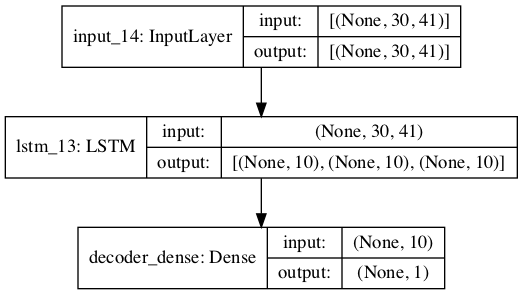

In [29]:
# plot model
plot_model(model, show_shapes=True, show_layer_names=True)

In [8]:
## Initializs storages for loss curves and correlation, dimension (#ESMs, #lead times, #runs, #epochs+1).
## Need #epochs+1, since we want to store results for untrained model plus after each epoch.
train_loss_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
val_loss_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
test_loss_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
train_correl_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
val_correl_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
test_correl_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))

## Loop over ESMs:
for m in range(len(ESMs)):
    
    # Get current ESM:
    ESM = ESMs[m]
    
    # Print status:
    print('ESM:',m+1,'of',len(ESMs))

    ## Loop over lead times:
    for l in range(len(lead_times)):
        
        # Get current lead time:
        lead_time = lead_times[l]
        
        # Print status:
        print('  lead time:',l+1,'of',len(lead_times))

        # Prepare inputs and target for current ESM and lead time:
        (
            train_input,
            train_target,
            val_input,
            val_target,
            test_input,
            test_target,
            train_mean,
            train_std,
            train_min,
            train_max,
        ) = prepare_inputs_and_target(    
            data_url=data_url,
            ESM=ESM,
            target_index=target_index,
            input_features=input_features,
            add_months=add_months,
            norm_target=norm_target,
            lead_time=lead_time,
            input_length=input_length,
            train_test_split=train_test_split,
            train_val_split=train_val_split,
            scale_norm=scale_norm,
        )
        
        # Loop over desired number of training runs:
        for r in range(n_runs):
            
            # Print status:
            print('    run:',r+1,'of',n_runs)
            
            ## Set up model:
            
            # Input layer
            input_shape = (input_length, n_features)
            encoder_inputs = Input(shape=input_shape)            

            # Encoder LSTM: Only return last hidden states.
            encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
                LSTM_units, return_sequences=False, return_state=True
            )(encoder_inputs)            

            # As decoder, use single fc unit:
            decoder_dense = Dense(1, name='decoder_dense')

            # Connect fc unit to encoder:
            output = decoder_dense(encoder_last_h2)
            
            # Define and compile model 
            model = Model(encoder_inputs, output, name='model_encoder_decoder')
            model.compile(loss=loss_function, optimizer=Adam(lr=learning_rate), metrics=['mse'])            
            
            ### Train model: Epoch-by-epoch
            
            ## Store results for untrained model:
            
            # Get model predictions on training, validation and test data:
            train_pred = model.predict(train_input)
            val_pred = model.predict(val_input)
            test_pred = model.predict(test_input)

            # Compute mse of model predictions vs. true targets:
            train_loss = np.mean((train_target-train_pred)**2)
            val_loss = np.mean((val_target-val_pred)**2)
            test_loss = np.mean((test_target-test_pred)**2)

            # Compute correlation coefficient of model predictions vs. true targets:
            train_correl = np.corrcoef(np.stack([train_target[:,0],train_pred[:,0]]))[0,1]
            val_correl = np.corrcoef(np.stack([val_target[:,0],val_pred[:,0]]))[0,1]
            test_correl = np.corrcoef(np.stack([test_target[:,0],test_pred[:,0]]))[0,1]
            
            # Store results:
            train_loss_all[m,l,r,0] = train_loss
            val_loss_all[m,l,r,0] = val_loss
            test_loss_all[m,l,r,0] = test_loss
            train_correl_all[m,l,r,0] = train_correl
            val_correl_all[m,l,r,0] = val_correl
            test_correl_all[m,l,r,0] = test_correl          
            
            # Loop over epochs:
            for e in range(n_epochs):
                
                # Train model for single epoch:
                history = model.fit(train_input, train_target, epochs=1, batch_size=batch_size, shuffle=True, verbose=0)

                ## Store results after current epoch:
            
                # Get model predictions on training, validation and test data:
                train_pred = model.predict(train_input)
                val_pred = model.predict(val_input)
                test_pred = model.predict(test_input)

                # Compute mse of model predictions vs. true targets:
                train_loss = np.mean((train_target-train_pred)**2)
                val_loss = np.mean((val_target-val_pred)**2)
                test_loss = np.mean((test_target-test_pred)**2)

                # Compute correlation coefficient of model predictions vs. true targets:
                train_correl = np.corrcoef(np.stack([train_target[:,0],train_pred[:,0]]))[0,1]
                val_correl = np.corrcoef(np.stack([val_target[:,0],val_pred[:,0]]))[0,1]
                test_correl = np.corrcoef(np.stack([test_target[:,0],test_pred[:,0]]))[0,1]

                # Store results:
                train_loss_all[m,l,r,e+1] = train_loss
                val_loss_all[m,l,r,e+1] = val_loss
                test_loss_all[m,l,r,e+1] = test_loss
                train_correl_all[m,l,r,e+1] = train_correl
                val_correl_all[m,l,r,e+1] = val_correl
                test_correl_all[m,l,r,e+1] = test_correl     

ESM: 1 of 1
  lead time: 1 of 1
    run: 1 of 1


2023-06-23 14:28:20.730562: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-23 14:28:20.944464: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


### Postprocessing

We now have loss ('mse') and correlation for complete training, validation and test data after each epoch (starting with untrained model as epoch 0).

Next, we aim to find the **minimum loss and maximum correlation on test data** for the **epoch with minimum validation loss**.
This search is done separately for each ESM, lead time and model run.

In a second step, we compute the **mean loss and correlation on test data over all runs**, separately for each ESM and lead time.

In [10]:
## Initializs storages for test loss (min) and correlation (max), where val loss takes its minimum,
## dimension (#ESMs, #lead times, #runs).
test_loss_min = np.zeros((len(ESMs),len(lead_times),n_runs))
test_correl_max = np.zeros((len(ESMs),len(lead_times),n_runs))

## Initializs storages for mean test loss and correlation, averaged over all training runs,
## dimension (#ESMs, #lead times).
test_loss_min_mean = np.zeros((len(ESMs),len(lead_times)))
test_correl_max_mean = np.zeros((len(ESMs),len(lead_times)))

## Loop over ESMs:
for m in range(len(ESMs)):
    
    ## Loop over lead times:
    for l in range(len(lead_times)):
        
        # Loop over desired number of training runs:
        for r in range(n_runs):
            
            # Get epoch with minimum validation loss for current ESM, lead time and training run:
            e_min = np.argmin(val_loss_all[m,l,r])
            
            # Store corresponding test loss and correlation:
            test_loss_min[m,l,r] = test_loss_all[m,l,r,e_min]
            test_correl_max[m,l,r] = test_correl_all[m,l,r,e_min]
            
        # Get mean test loss and correlation over all training runs, for current ESM and lead time:
        test_loss_min_mean[m,l] = np.mean(test_loss_min[m,l])
        test_correl_max_mean[m,l] = np.mean(test_correl_max[m,l])

### Results: LSTM encoder/decoder without attention

In [11]:
test_loss_min_mean

array([[0.88501108]])

In [12]:
test_correl_max_mean

array([[0.44680043]])

### LSTM encoder/decoder without attention - single time step processing

This serves as preparation for implementing input attention in a later step.

In [51]:
### Set up model: Single run

# Input layer: Provide all time steps' inputs
input_shape = (input_length, n_features)
encoder_inputs = Input(shape=input_shape)
print(encoder_inputs)

# Initialize Encoder LSTM: Only process first time step's inputs
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
 LSTM_units, return_sequences=False, return_state=True)(encoder_inputs[:,0:1,:])
print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)

# Run over remaining time steps: Process current time step's inputs. Initialize LSTM's hidden and cell states
# with previous time step's hidden and cell states.
for t in np.arange(1,input_length,1):
    
    encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
        LSTM_units, return_sequences=False, return_state=True)(
        encoder_inputs[:,t:t+1,:], 
        initial_state=[encoder_last_h2, encoder_last_c]
    )  
    
# As decoder, use single fc unit:
decoder_dense = Dense(1, name='decoder_dense')

# Connect fc unit to encoder:
output = decoder_dense(encoder_last_h2)
# print(output)

# Define and compile model 
model = Model(encoder_inputs, output, name='model_encoder_decoder')
model.compile(loss=loss_function, optimizer=Adam(lr=learning_rate), metrics=['mse'])
#model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 30, 41), dtype=tf.float32, name='input_9'), name='input_9', description="created by layer 'input_9'")


In [56]:
## Initializs storages for loss curves and correlation, dimension (#ESMs, #lead times, #runs, #epochs+1).
## Need #epochs+1, since we want to store results for untrained model plus after each epoch.
train_loss_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
val_loss_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
test_loss_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
train_correl_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
val_correl_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
test_correl_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))

## Loop over ESMs:
for m in range(len(ESMs)):
    
    # Get current ESM:
    ESM = ESMs[m]
    
    # Print status:
    print('ESM:',m+1,'of',len(ESMs))

    ## Loop over lead times:
    for l in range(len(lead_times)):
        
        # Get current lead time:
        lead_time = lead_times[l]
        
        # Print status:
        print('  lead time:',l+1,'of',len(lead_times))

        # Prepare inputs and target for current ESM and lead time:
        (
            train_input,
            train_target,
            val_input,
            val_target,
            test_input,
            test_target,
            train_mean,
            train_std,
            train_min,
            train_max,
        ) = prepare_inputs_and_target(    
            data_url=data_url,
            ESM=ESM,
            target_index=target_index,
            input_features=input_features,
            add_months=add_months,
            norm_target=norm_target,
            lead_time=lead_time,
            input_length=input_length,
            train_test_split=train_test_split,
            train_val_split=train_val_split,
            scale_norm=scale_norm,
        )
        
        # Loop over desired number of training runs:
        for r in range(n_runs):
            
            # Print status:
            print('    run:',r+1,'of',n_runs)
            
            ## Set up model:
            
            # Input layer: Provide all time steps' inputs
            input_shape = (input_length, n_features)
            encoder_inputs = Input(shape=input_shape)
            
            # Initialize Encoder LSTM: Only process first time step's inputs
            encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
                LSTM_units, return_sequences=False, return_state=True)(encoder_inputs[:,0:1,:])
            
            # Run over remaining time steps: Process current time step's inputs. Initialize LSTM's hidden and cell states
            # with previous time step's hidden and cell states.
            for t in np.arange(1,input_length,1):

                encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
                    LSTM_units, return_sequences=False, return_state=True)(
                    encoder_inputs[:,t:t+1,:], 
                    initial_state=[encoder_last_h2, encoder_last_c]
                )  

            # As decoder, use single fc unit:
            decoder_dense = Dense(1, name='decoder_dense')

            # Connect fc unit to encoder:
            output = decoder_dense(encoder_last_h2)
            
            # Define and compile model 
            model = Model(encoder_inputs, output, name='model_encoder_decoder')
            model.compile(loss=loss_function, optimizer=Adam(lr=learning_rate), metrics=['mse'])
            
            ### Train model: Epoch-by-epoch
            
            ## Store results for untrained model:
            
            # Get model predictions on training, validation and test data:
            train_pred = model.predict(train_input)
            val_pred = model.predict(val_input)
            test_pred = model.predict(test_input)

            # Compute mse of model predictions vs. true targets:
            train_loss = np.mean((train_target-train_pred)**2)
            val_loss = np.mean((val_target-val_pred)**2)
            test_loss = np.mean((test_target-test_pred)**2)

            # Compute correlation coefficient of model predictions vs. true targets:
            train_correl = np.corrcoef(np.stack([train_target[:,0],train_pred[:,0]]))[0,1]
            val_correl = np.corrcoef(np.stack([val_target[:,0],val_pred[:,0]]))[0,1]
            test_correl = np.corrcoef(np.stack([test_target[:,0],test_pred[:,0]]))[0,1]
            
            # Store results:
            train_loss_all[m,l,r,0] = train_loss
            val_loss_all[m,l,r,0] = val_loss
            test_loss_all[m,l,r,0] = test_loss
            train_correl_all[m,l,r,0] = train_correl
            val_correl_all[m,l,r,0] = val_correl
            test_correl_all[m,l,r,0] = test_correl          
            
            # Loop over epochs:
            for e in range(n_epochs):
                
                # Print status:
                print('      epoch:',e+1,'of',n_epochs)
                
                # Train model for single epoch:
                history = model.fit(train_input, train_target, epochs=1, batch_size=batch_size, shuffle=True, verbose=0)

                ## Store results after current epoch:
            
                # Get model predictions on training, validation and test data:
                train_pred = model.predict(train_input)
                val_pred = model.predict(val_input)
                test_pred = model.predict(test_input)

                # Compute mse of model predictions vs. true targets:
                train_loss = np.mean((train_target-train_pred)**2)
                val_loss = np.mean((val_target-val_pred)**2)
                test_loss = np.mean((test_target-test_pred)**2)

                # Compute correlation coefficient of model predictions vs. true targets:
                train_correl = np.corrcoef(np.stack([train_target[:,0],train_pred[:,0]]))[0,1]
                val_correl = np.corrcoef(np.stack([val_target[:,0],val_pred[:,0]]))[0,1]
                test_correl = np.corrcoef(np.stack([test_target[:,0],test_pred[:,0]]))[0,1]

                # Store results:
                train_loss_all[m,l,r,e+1] = train_loss
                val_loss_all[m,l,r,e+1] = val_loss
                test_loss_all[m,l,r,e+1] = test_loss
                train_correl_all[m,l,r,e+1] = train_correl
                val_correl_all[m,l,r,e+1] = val_correl
                test_correl_all[m,l,r,e+1] = test_correl

ESM: 1 of 1
  lead time: 1 of 1
    run: 1 of 1


### Postprocessing

We now have loss ('mse') and correlation for complete training, validation and test data after each epoch (starting with untrained model as epoch 0).

Next, we aim to find the **minimum loss and maximum correlation on test data** for the **epoch with minimum validation loss**.
This search is done separately for each ESM, lead time and model run.

In a second step, we compute the **mean loss and correlation on test data over all runs**, separately for each ESM and lead time.

In [58]:
## Initializs storages for test loss (min) and correlation (max), where val loss takes its minimum,
## dimension (#ESMs, #lead times, #runs).
test_loss_min = np.zeros((len(ESMs),len(lead_times),n_runs))
test_correl_max = np.zeros((len(ESMs),len(lead_times),n_runs))

## Initializs storages for mean test loss and correlation, averaged over all training runs,
## dimension (#ESMs, #lead times).
test_loss_min_mean = np.zeros((len(ESMs),len(lead_times)))
test_correl_max_mean = np.zeros((len(ESMs),len(lead_times)))

## Loop over ESMs:
for m in range(len(ESMs)):
    
    ## Loop over lead times:
    for l in range(len(lead_times)):
        
        # Loop over desired number of training runs:
        for r in range(n_runs):
            
            # Get epoch with minimum validation loss for current ESM, lead time and training run:
            e_min = np.argmin(val_loss_all[m,l,r])
            
            # Store corresponding test loss and correlation:
            test_loss_min[m,l,r] = test_loss_all[m,l,r,e_min]
            test_correl_max[m,l,r] = test_correl_all[m,l,r,e_min]
            
        # Get mean test loss and correlation over all training runs, for current ESM and lead time:
        test_loss_min_mean[m,l] = np.mean(test_loss_min[m,l])
        test_correl_max_mean[m,l] = np.mean(test_correl_max[m,l])

### Results: LSTM encoder/decoder without attention - single time step processing

In [59]:
test_loss_min_mean

array([[0.88123547]])

In [60]:
test_correl_max_mean

array([[0.44805317]])

### LSTM encoder/decoder - with 'naive' input attention

In [168]:
## Initializs storages for loss curves and correlation, dimension (#ESMs, #lead times, #runs, #epochs+1).
## Need #epochs+1, since we want to store results for untrained model plus after each epoch.
train_loss_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
val_loss_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
test_loss_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
train_correl_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
val_correl_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
test_correl_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))

## Loop over ESMs:
for m in range(len(ESMs)):
    
    # Get current ESM:
    ESM = ESMs[m]
    
    # Print status:
    print('ESM:',m+1,'of',len(ESMs))

    ## Loop over lead times:
    for l in range(len(lead_times)):
        
        # Get current lead time:
        lead_time = lead_times[l]
        
        # Print status:
        print('  lead time:',l+1,'of',len(lead_times))

        # Prepare inputs and target for current ESM and lead time:
        (
            train_input,
            train_target,
            val_input,
            val_target,
            test_input,
            test_target,
            train_mean,
            train_std,
            train_min,
            train_max,
        ) = prepare_inputs_and_target(    
            data_url=data_url,
            ESM=ESM,
            target_index=target_index,
            input_features=input_features,
            add_months=add_months,
            norm_target=norm_target,
            lead_time=lead_time,
            input_length=input_length,
            train_test_split=train_test_split,
            train_val_split=train_val_split,
            scale_norm=scale_norm,
        )
        
        # Prepare initial ONEs for input attention:
        input_attention_init_train = np.ones(train_input.shape)
        input_attention_init_val = np.ones(val_input.shape)
        input_attention_init_test = np.ones(test_input.shape)
                
        # Loop over desired number of training runs:
        for r in range(n_runs):
            
            # Print status:
            print('    run:',r+1,'of',n_runs)
            
            ## Set up model:
            
            # Input layer: Provide all time steps' inputs
            encoder_inputs = Input(shape=(input_length, n_features))
            
            ## Set up input attention:

            # Set up another input layer for initializing input attention weights with ONEs for ALL time steps:
            input_attention_init = Input(shape=(input_length, n_features))

            # Set up input attention weights as Dense layer: Connect to first time steps initialization.
            input_attention_weights = Dense(n_features)(input_attention_init[:,0:1,:])
            
            # Softmax input attention weights:
            input_attention_softmax = tf.nn.softmax(input_attention_weights)
            
            # Element-wise multiplication of softmaxed input attention weights with current time step's inputs:
            input_attention = multiply([input_attention_softmax, encoder_inputs[:,0:1,:]])
            
            # Initialize Encoder LSTM: Only process first time step's inputs, respecting input attention!
            encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
                LSTM_units, return_sequences=False, return_state=True)(input_attention)
            
            # Run over remaining time steps: Process current time step's inputs.
            for t in np.arange(1,input_length,1):

                # Set up input attention weights as Dense layer: Connect to current time steps initialization.
                input_attention_weights = Dense(n_features)(input_attention_init[:,t:t+1,:])

                # Softmax input attention weights:
                input_attention_softmax = tf.nn.softmax(input_attention_weights)

                # Element-wise multiplication of softmaxed input attention weights with current time step's inputs:
                input_attention = multiply([input_attention_softmax, encoder_inputs[:,t:t+1,:]])

                # Initialize LSTM's hidden and cell states with previous time step's hidden and cell states. 
                # Respect input attention in every time step!
                encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
                    LSTM_units, return_sequences=False, return_state=True)(
                    input_attention, 
                    initial_state=[encoder_last_h2, encoder_last_c]
                )  

            # As decoder, use single fc unit:
            decoder_dense = Dense(1, name='decoder_dense')

            # Connect fc unit to encoder:
            output = decoder_dense(encoder_last_h2)
            
            # Define and compile model 
            model = Model([encoder_inputs ,input_attention_init], output, name='model_encoder_decoder')
            model.compile(loss=loss_function, optimizer=Adam(lr=learning_rate), metrics=['mse'])
            
            ### Train model: Epoch-by-epoch
            
            ## Store results for untrained model:
            
            # Get model predictions on training, validation and test data:
            train_pred = model.predict([train_input,input_attention_init_train])
            val_pred = model.predict([val_input,input_attention_init_val])
            test_pred = model.predict([test_input,input_attention_init_test])

            # Compute mse of model predictions vs. true targets:
            train_loss = np.mean((train_target-train_pred)**2)
            val_loss = np.mean((val_target-val_pred)**2)
            test_loss = np.mean((test_target-test_pred)**2)

            # Compute correlation coefficient of model predictions vs. true targets:
            train_correl = np.corrcoef(np.stack([train_target[:,0],train_pred[:,0]]))[0,1]
            val_correl = np.corrcoef(np.stack([val_target[:,0],val_pred[:,0]]))[0,1]
            test_correl = np.corrcoef(np.stack([test_target[:,0],test_pred[:,0]]))[0,1]
            
            # Store results:
            train_loss_all[m,l,r,0] = train_loss
            val_loss_all[m,l,r,0] = val_loss
            test_loss_all[m,l,r,0] = test_loss
            train_correl_all[m,l,r,0] = train_correl
            val_correl_all[m,l,r,0] = val_correl
            test_correl_all[m,l,r,0] = test_correl          
            
            # Loop over epochs:
            for e in range(n_epochs):
                
                # Print status:
                print('      epoch:',e+1,'of',n_epochs)
                
                # Train model for single epoch:
                history = model.fit([train_input,input_attention_init_train], train_target, epochs=1, batch_size=batch_size, shuffle=True, verbose=0)

                ## Store results after current epoch:
            
                # Get model predictions on training, validation and test data:
                train_pred = model.predict([train_input,input_attention_init_train])
                val_pred = model.predict([val_input,input_attention_init_val])
                test_pred = model.predict([test_input,input_attention_init_test])

                # Compute mse of model predictions vs. true targets:
                train_loss = np.mean((train_target-train_pred)**2)
                val_loss = np.mean((val_target-val_pred)**2)
                test_loss = np.mean((test_target-test_pred)**2)

                # Compute correlation coefficient of model predictions vs. true targets:
                train_correl = np.corrcoef(np.stack([train_target[:,0],train_pred[:,0]]))[0,1]
                val_correl = np.corrcoef(np.stack([val_target[:,0],val_pred[:,0]]))[0,1]
                test_correl = np.corrcoef(np.stack([test_target[:,0],test_pred[:,0]]))[0,1]

                # Store results:
                train_loss_all[m,l,r,e+1] = train_loss
                val_loss_all[m,l,r,e+1] = val_loss
                test_loss_all[m,l,r,e+1] = test_loss
                train_correl_all[m,l,r,e+1] = train_correl
                val_correl_all[m,l,r,e+1] = val_correl
                test_correl_all[m,l,r,e+1] = test_correl

ESM: 1 of 1
  lead time: 1 of 1
    run: 1 of 1
      epoch: 1 of 10
      epoch: 2 of 10
      epoch: 3 of 10
      epoch: 4 of 10
      epoch: 5 of 10
      epoch: 6 of 10
      epoch: 7 of 10
      epoch: 8 of 10
      epoch: 9 of 10
      epoch: 10 of 10


### Postprocessing

We now have loss ('mse') and correlation for complete training, validation and test data after each epoch (starting with untrained model as epoch 0).

Next, we aim to find the **minimum loss and maximum correlation on test data** for the **epoch with minimum validation loss**.
This search is done separately for each ESM, lead time and model run.

In a second step, we compute the **mean loss and correlation on test data over all runs**, separately for each ESM and lead time.

In [169]:
## Initializs storages for test loss (min) and correlation (max), where val loss takes its minimum,
## dimension (#ESMs, #lead times, #runs).
test_loss_min = np.zeros((len(ESMs),len(lead_times),n_runs))
test_correl_max = np.zeros((len(ESMs),len(lead_times),n_runs))

## Initializs storages for mean test loss and correlation, averaged over all training runs,
## dimension (#ESMs, #lead times).
test_loss_min_mean = np.zeros((len(ESMs),len(lead_times)))
test_correl_max_mean = np.zeros((len(ESMs),len(lead_times)))

## Loop over ESMs:
for m in range(len(ESMs)):
    
    ## Loop over lead times:
    for l in range(len(lead_times)):
        
        # Loop over desired number of training runs:
        for r in range(n_runs):
            
            # Get epoch with minimum validation loss for current ESM, lead time and training run:
            e_min = np.argmin(val_loss_all[m,l,r])
            
            # Store corresponding test loss and correlation:
            test_loss_min[m,l,r] = test_loss_all[m,l,r,e_min]
            test_correl_max[m,l,r] = test_correl_all[m,l,r,e_min]
            
        # Get mean test loss and correlation over all training runs, for current ESM and lead time:
        test_loss_min_mean[m,l] = np.mean(test_loss_min[m,l])
        test_correl_max_mean[m,l] = np.mean(test_correl_max[m,l])

### Results: LSTM encoder/decoder - with 'naive' input attention

In [117]:
# First run:
test_loss_min_mean

array([[0.91021372]])

In [170]:
# Second run:
test_loss_min_mean

array([[0.93186007]])

In [118]:
# First run:
test_correl_max_mean

array([[0.41801225]])

In [171]:
# Second run:
test_correl_max_mean

array([[0.39342532]])

In [119]:
model.layers

In [172]:
## Get softmaxed attention weights for input attention:

# Set dummy inputs of zeros and ones:
dummy_input_zeros = np.zeros((1,input_length,n_features))
dummy_input_ones = np.ones((1,input_length,n_features))

# Set model input:
inp = model.input

# Initialize storage for input attention weights of all time steps for all input features:
attention_weights = []
    
## Loop over layers:

for out_n in range(len(model.layers)):
    
    # Set model output:
    out = model.layers[out_n].output

    # Combine input and output as new functional model:
    func = K.function([inp], [out])
    
    # Output, only for softmaxed attention weights:
    if 'TFOpLambda' in str(model.layers[out_n]):
        # print('\nOut_n:',out_n,', SUM:',np.sum(np.array(func([dummy_input_zeros,dummy_input_ones]))))
        # print(np.array(func([dummy_input_zeros,dummy_input_ones])))
        # print(np.array(func([dummy_input_zeros,dummy_input_ones])).shape)
        
        # Store attention weights:
        attention_weights.append(np.array(func([dummy_input_zeros,dummy_input_ones]))[0,0,0])

# Convert list of attention weights into numpy array and swap axes:
attention_weights = np.swapaxes(np.array(attention_weights),0,1)

In [160]:
# Create extended input features, including months:
input_features_extended = input_features.copy()
input_features_extended.append('Jan')
input_features_extended.append('Feb')
input_features_extended.append('Mar')
input_features_extended.append('Apr')
input_features_extended.append('May')
input_features_extended.append('Jun')
input_features_extended.append('Jul')
input_features_extended.append('Aug')
input_features_extended.append('Sep')
input_features_extended.append('Oct')
input_features_extended.append('Nov')
input_features_extended.append('Dec')

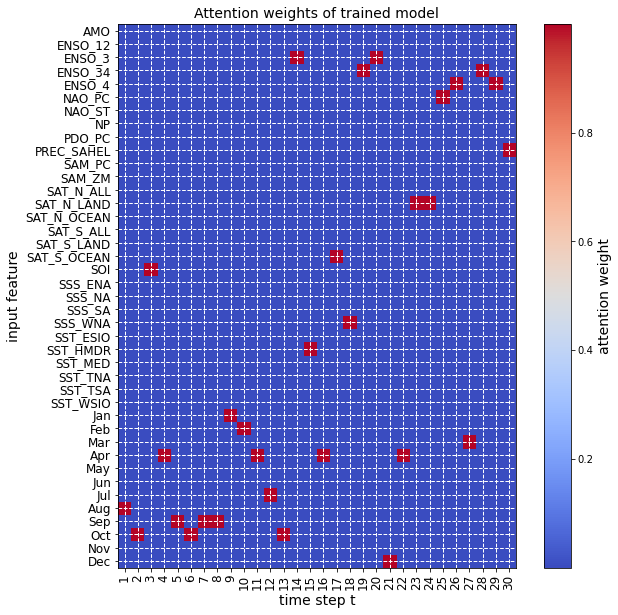

In [164]:
# Show attention weights of trained model as heat map:
fig, ax = plt.subplots(figsize=(10, 10))
im = plt.imshow(attention_weights, cmap="coolwarm", interpolation='nearest')#, vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('attention weight', fontsize=14)
plt.title('Attention weights of trained model', fontsize=14)
plt.xlabel('time step t', fontsize=14)
plt.ylabel('input feature', fontsize=14)
plt.xticks(np.arange(0, input_length, step=1),np.arange(1, input_length+1, step=1), fontsize=12, rotation=90)
plt.yticks(np.arange(0, n_features, step=1), input_features_extended, fontsize=12)
ax.grid(color='white', linestyle='--', linewidth=1)
plt.show()

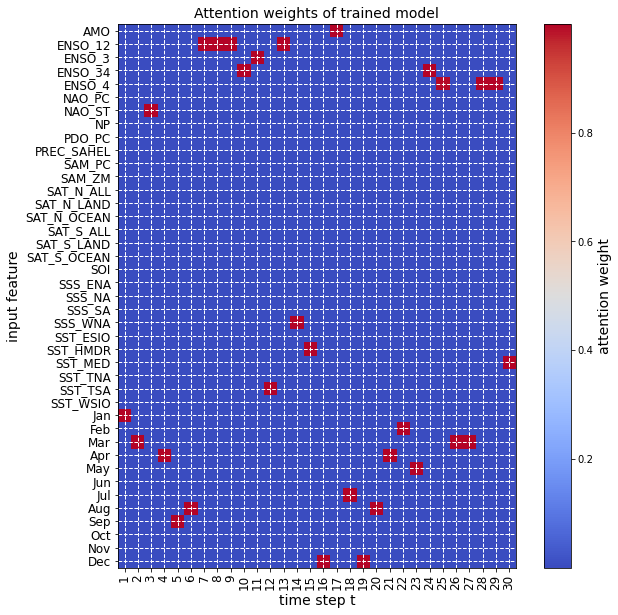

In [173]:
### Check, if the result is reproducible, have another trainings run:

# Show attention weights of trained model as heat map:
fig, ax = plt.subplots(figsize=(10, 10))
im = plt.imshow(attention_weights, cmap="coolwarm", interpolation='nearest')#, vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('attention weight', fontsize=14)
plt.title('Attention weights of trained model', fontsize=14)
plt.xlabel('time step t', fontsize=14)
plt.ylabel('input feature', fontsize=14)
plt.xticks(np.arange(0, input_length, step=1),np.arange(1, input_length+1, step=1), fontsize=12, rotation=90)
plt.yticks(np.arange(0, n_features, step=1), input_features_extended, fontsize=12)
ax.grid(color='white', linestyle='--', linewidth=1)
plt.show()

In [165]:
### For comparison: Attention weights for UN-trained model:

## Set up model:
            
# Input layer: Provide all time steps' inputs
encoder_inputs = Input(shape=(input_length, n_features))

## Set up input attention:

# Set up another input layer for initializing input attention weights with ONEs for ALL time steps:
input_attention_init = Input(shape=(input_length, n_features))

# Set up input attention weights as Dense layer: Connect to first time steps initialization.
input_attention_weights = Dense(n_features)(input_attention_init[:,0:1,:])

# Softmax input attention weights:
input_attention_softmax = tf.nn.softmax(input_attention_weights)

# Element-wise multiplication of softmaxed input attention weights with current time step's inputs:
input_attention = multiply([input_attention_softmax, encoder_inputs[:,0:1,:]])

# Initialize Encoder LSTM: Only process first time step's inputs, respecting input attention!
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
    LSTM_units, return_sequences=False, return_state=True)(input_attention)

# Run over remaining time steps: Process current time step's inputs.
for t in np.arange(1,input_length,1):

    # Set up input attention weights as Dense layer: Connect to current time steps initialization.
    input_attention_weights = Dense(n_features)(input_attention_init[:,t:t+1,:])

    # Softmax input attention weights:
    input_attention_softmax = tf.nn.softmax(input_attention_weights)

    # Element-wise multiplication of softmaxed input attention weights with current time step's inputs:
    input_attention = multiply([input_attention_softmax, encoder_inputs[:,t:t+1,:]])

    # Initialize LSTM's hidden and cell states with previous time step's hidden and cell states. 
    # Respect input attention in every time step!
    encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
        LSTM_units, return_sequences=False, return_state=True)(
        input_attention, 
        initial_state=[encoder_last_h2, encoder_last_c]
    )  

# As decoder, use single fc unit:
decoder_dense = Dense(1, name='decoder_dense')

# Connect fc unit to encoder:
output = decoder_dense(encoder_last_h2)

# Define and compile model 
model = Model([encoder_inputs ,input_attention_init], output, name='model_encoder_decoder')
model.compile(loss=loss_function, optimizer=Adam(lr=learning_rate), metrics=['mse'])

In [166]:
## Get softmaxed attention weights for input attention:

# Set dummy inputs of zeros and ones:
dummy_input_zeros = np.zeros((1,input_length,n_features))
dummy_input_ones = np.ones((1,input_length,n_features))

# Set model input:
inp = model.input

# Initialize storage for input attention weights of all time steps for all input features:
attention_weights = []
    
## Loop over layers:

for out_n in range(len(model.layers)):
    
    # Set model output:
    out = model.layers[out_n].output

    # Combine input and output as new functional model:
    func = K.function([inp], [out])
    
    # Output, only for softmaxed attention weights:
    if 'TFOpLambda' in str(model.layers[out_n]):
        # print('\nOut_n:',out_n,', SUM:',np.sum(np.array(func([dummy_input_zeros,dummy_input_ones]))))
        # print(np.array(func([dummy_input_zeros,dummy_input_ones])))
        # print(np.array(func([dummy_input_zeros,dummy_input_ones])).shape)
        
        # Store attention weights:
        attention_weights.append(np.array(func([dummy_input_zeros,dummy_input_ones]))[0,0,0])

# Convert list of attention weights into numpy array and swap axes:
attention_weights = np.swapaxes(np.array(attention_weights),0,1)

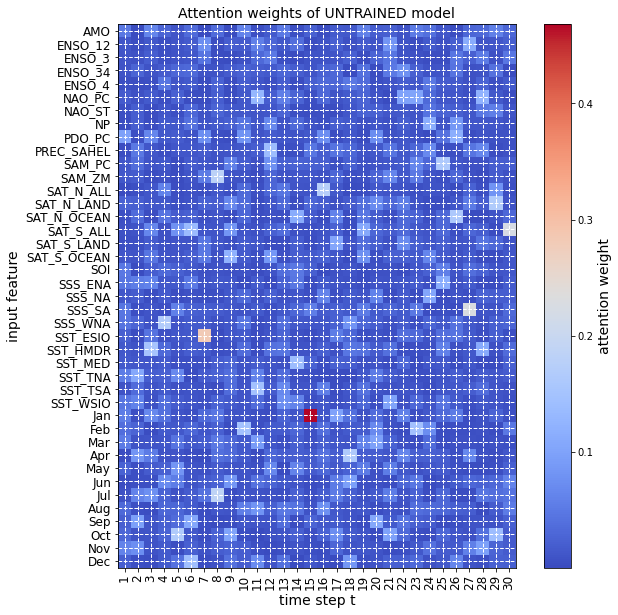

In [167]:
# Show attention weights of untrained model as heat map:
fig, ax = plt.subplots(figsize=(10, 10))
im = plt.imshow(attention_weights, cmap="coolwarm", interpolation='nearest')#, vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('attention weight', fontsize=14)
plt.title('Attention weights of UNTRAINED model', fontsize=14)
plt.xlabel('time step t', fontsize=14)
plt.ylabel('input feature', fontsize=14)
plt.xticks(np.arange(0, input_length, step=1),np.arange(1, input_length+1, step=1), fontsize=12, rotation=90)
plt.yticks(np.arange(0, n_features, step=1), input_features_extended, fontsize=12)
ax.grid(color='white', linestyle='--', linewidth=1)
plt.show()

### Discussion: LSTM encoder/decoder - with 'naive' input attention

In our first attempt to implement a **naive input attention**, we used softmaxed attention weights.
Somehow, that leads to a trained model, that only focusses on a **single input feature** per time step, which is not desired.

Additionally, the resulting heat map showing the attention weights of our trained model is not reproducible for different runs.

**Next:** Try - as modification - to omit the softmaxing.

### LSTM encoder/decoder - with 'naive' input attention - but: No softmaxing!

In [205]:
## Initializs storages for loss curves and correlation, dimension (#ESMs, #lead times, #runs, #epochs+1).
## Need #epochs+1, since we want to store results for untrained model plus after each epoch.
train_loss_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
val_loss_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
test_loss_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
train_correl_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
val_correl_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))
test_correl_all = np.zeros((len(ESMs),len(lead_times),n_runs,n_epochs+1))

## Loop over ESMs:
for m in range(len(ESMs)):
    
    # Get current ESM:
    ESM = ESMs[m]
    
    # Print status:
    print('ESM:',m+1,'of',len(ESMs))

    ## Loop over lead times:
    for l in range(len(lead_times)):
        
        # Get current lead time:
        lead_time = lead_times[l]
        
        # Print status:
        print('  lead time:',l+1,'of',len(lead_times))

        # Prepare inputs and target for current ESM and lead time:
        (
            train_input,
            train_target,
            val_input,
            val_target,
            test_input,
            test_target,
            train_mean,
            train_std,
            train_min,
            train_max,
        ) = prepare_inputs_and_target(    
            data_url=data_url,
            ESM=ESM,
            target_index=target_index,
            input_features=input_features,
            add_months=add_months,
            norm_target=norm_target,
            lead_time=lead_time,
            input_length=input_length,
            train_test_split=train_test_split,
            train_val_split=train_val_split,
            scale_norm=scale_norm,
        )
        
        # Prepare initial ONEs for input attention:
        input_attention_init_train = np.ones(train_input.shape)
        input_attention_init_val = np.ones(val_input.shape)
        input_attention_init_test = np.ones(test_input.shape)
                
        # Loop over desired number of training runs:
        for r in range(n_runs):
            
            # Print status:
            print('    run:',r+1,'of',n_runs)
            
            ## Set up model:
            
            # Input layer: Provide all time steps' inputs
            encoder_inputs = Input(shape=(input_length, n_features))
            
            ## Set up input attention:

            # Set up another input layer for initializing input attention weights with ONEs for ALL time steps:
            input_attention_init = Input(shape=(input_length, n_features))

            # Set up input attention weights as Dense layer: Connect to first time steps initialization.
            input_attention_weights = Dense(n_features)(input_attention_init[:,0:1,:])
            
            # Element-wise multiplication of input attention weights with current time step's inputs:
            input_attention = multiply([input_attention_weights, encoder_inputs[:,0:1,:]])
            
            # Initialize Encoder LSTM: Only process first time step's inputs, respecting input attention!
            encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
                LSTM_units, return_sequences=False, return_state=True)(input_attention)
            
            # Run over remaining time steps: Process current time step's inputs.
            for t in np.arange(1,input_length,1):

                # Set up input attention weights as Dense layer: Connect to current time steps initialization.
                input_attention_weights = Dense(n_features)(input_attention_init[:,t:t+1,:])

                # Element-wise multiplication of input attention weights with current time step's inputs:
                input_attention = multiply([input_attention_weights, encoder_inputs[:,t:t+1,:]])

                # Initialize LSTM's hidden and cell states with previous time step's hidden and cell states. 
                # Respect input attention in every time step!
                encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
                    LSTM_units, return_sequences=False, return_state=True)(
                    input_attention, 
                    initial_state=[encoder_last_h2, encoder_last_c]
                )  

            # As decoder, use single fc unit:
            decoder_dense = Dense(1, name='decoder_dense')

            # Connect fc unit to encoder:
            output = decoder_dense(encoder_last_h2)
            
            # Define and compile model 
            model = Model([encoder_inputs ,input_attention_init], output, name='model_encoder_decoder')
            model.compile(loss=loss_function, optimizer=Adam(lr=learning_rate), metrics=['mse'])
            
            ### Train model: Epoch-by-epoch
            
            ## Store results for untrained model:
            
            # Get model predictions on training, validation and test data:
            train_pred = model.predict([train_input,input_attention_init_train])
            val_pred = model.predict([val_input,input_attention_init_val])
            test_pred = model.predict([test_input,input_attention_init_test])

            # Compute mse of model predictions vs. true targets:
            train_loss = np.mean((train_target-train_pred)**2)
            val_loss = np.mean((val_target-val_pred)**2)
            test_loss = np.mean((test_target-test_pred)**2)

            # Compute correlation coefficient of model predictions vs. true targets:
            train_correl = np.corrcoef(np.stack([train_target[:,0],train_pred[:,0]]))[0,1]
            val_correl = np.corrcoef(np.stack([val_target[:,0],val_pred[:,0]]))[0,1]
            test_correl = np.corrcoef(np.stack([test_target[:,0],test_pred[:,0]]))[0,1]
            
            # Store results:
            train_loss_all[m,l,r,0] = train_loss
            val_loss_all[m,l,r,0] = val_loss
            test_loss_all[m,l,r,0] = test_loss
            train_correl_all[m,l,r,0] = train_correl
            val_correl_all[m,l,r,0] = val_correl
            test_correl_all[m,l,r,0] = test_correl          
            
            # Loop over epochs:
            for e in range(n_epochs):
                
                # Print status:
                print('      epoch:',e+1,'of',n_epochs)
                
                # Train model for single epoch:
                history = model.fit([train_input,input_attention_init_train], train_target, epochs=1, batch_size=batch_size, shuffle=True, verbose=0)

                ## Store results after current epoch:
            
                # Get model predictions on training, validation and test data:
                train_pred = model.predict([train_input,input_attention_init_train])
                val_pred = model.predict([val_input,input_attention_init_val])
                test_pred = model.predict([test_input,input_attention_init_test])

                # Compute mse of model predictions vs. true targets:
                train_loss = np.mean((train_target-train_pred)**2)
                val_loss = np.mean((val_target-val_pred)**2)
                test_loss = np.mean((test_target-test_pred)**2)

                # Compute correlation coefficient of model predictions vs. true targets:
                train_correl = np.corrcoef(np.stack([train_target[:,0],train_pred[:,0]]))[0,1]
                val_correl = np.corrcoef(np.stack([val_target[:,0],val_pred[:,0]]))[0,1]
                test_correl = np.corrcoef(np.stack([test_target[:,0],test_pred[:,0]]))[0,1]

                # Store results:
                train_loss_all[m,l,r,e+1] = train_loss
                val_loss_all[m,l,r,e+1] = val_loss
                test_loss_all[m,l,r,e+1] = test_loss
                train_correl_all[m,l,r,e+1] = train_correl
                val_correl_all[m,l,r,e+1] = val_correl
                test_correl_all[m,l,r,e+1] = test_correl

ESM: 1 of 1
  lead time: 1 of 1
    run: 1 of 1
      epoch: 1 of 10
      epoch: 2 of 10
      epoch: 3 of 10
      epoch: 4 of 10
      epoch: 5 of 10
      epoch: 6 of 10
      epoch: 7 of 10
      epoch: 8 of 10
      epoch: 9 of 10
      epoch: 10 of 10


### Postprocessing

We now have loss ('mse') and correlation for complete training, validation and test data after each epoch (starting with untrained model as epoch 0).

Next, we aim to find the **minimum loss and maximum correlation on test data** for the **epoch with minimum validation loss**.
This search is done separately for each ESM, lead time and model run.

In a second step, we compute the **mean loss and correlation on test data over all runs**, separately for each ESM and lead time.

In [206]:
## Initializs storages for test loss (min) and correlation (max), where val loss takes its minimum,
## dimension (#ESMs, #lead times, #runs).
test_loss_min = np.zeros((len(ESMs),len(lead_times),n_runs))
test_correl_max = np.zeros((len(ESMs),len(lead_times),n_runs))

## Initializs storages for mean test loss and correlation, averaged over all training runs,
## dimension (#ESMs, #lead times).
test_loss_min_mean = np.zeros((len(ESMs),len(lead_times)))
test_correl_max_mean = np.zeros((len(ESMs),len(lead_times)))

## Loop over ESMs:
for m in range(len(ESMs)):
    
    ## Loop over lead times:
    for l in range(len(lead_times)):
        
        # Loop over desired number of training runs:
        for r in range(n_runs):
            
            # Get epoch with minimum validation loss for current ESM, lead time and training run:
            e_min = np.argmin(val_loss_all[m,l,r])
            
            # Store corresponding test loss and correlation:
            test_loss_min[m,l,r] = test_loss_all[m,l,r,e_min]
            test_correl_max[m,l,r] = test_correl_all[m,l,r,e_min]
            
        # Get mean test loss and correlation over all training runs, for current ESM and lead time:
        test_loss_min_mean[m,l] = np.mean(test_loss_min[m,l])
        test_correl_max_mean[m,l] = np.mean(test_correl_max[m,l])

### Results: LSTM encoder/decoder - with 'naive' input attention - but: No softmaxing!

In [207]:
# First run:
test_loss_min_mean

array([[0.91336987]])

In [194]:
# Second run:
test_loss_min_mean

array([[0.90014047]])

In [208]:
# First run:
test_correl_max_mean

array([[0.42121826]])

In [195]:
# Second run:
test_correl_max_mean

array([[0.4285565]])

In [209]:
## Get softmaxed attention weights for input attention:

# Set dummy inputs of zeros and ones:
dummy_input_zeros = np.zeros((1,input_length,n_features))
dummy_input_ones = np.ones((1,input_length,n_features))

# Set model input:
inp = model.input

# Initialize storage for input attention weights of all time steps for all input features:
attention_weights = []

# Initialize counter:
counter = 0

## Loop over layers:
for out_n in range(len(model.layers)):
    
    # Set model output:
    out = model.layers[out_n].output

    # Combine input and output as new functional model:
    func = K.function([inp], [out])
    
    # Output, only Dense layers (but omit final Dense layer, since that is the output layer!):
    if 'Dense' in str(model.layers[out_n]):
        
        # Increase counter:
        counter += 1
        
        # print('\nOut_n:',out_n,', SUM:',np.sum(np.array(func([dummy_input_zeros,dummy_input_ones]))))
        # print(np.array(func([dummy_input_zeros,dummy_input_ones])))
        # print(np.array(func([dummy_input_zeros,dummy_input_ones])).shape)
        
        # Store attention weights, only if counter didn't exceed number of time steps, yet:
        if counter <= input_length:
            attention_weights.append(np.array(func([dummy_input_zeros,dummy_input_ones]))[0,0,0])

# Convert list of attention weights into numpy array and swap axes:
attention_weights = np.swapaxes(np.array(attention_weights),0,1)

# Softmax input attention weights to sum to ONE per time step:
attention_weights = scipy.special.softmax(attention_weights, axis=0)

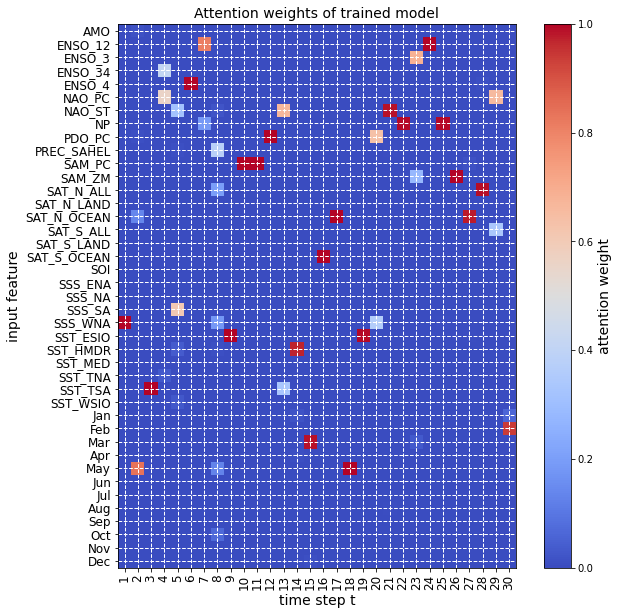

In [210]:
# Show attention weights of trained model as heat map:
fig, ax = plt.subplots(figsize=(10, 10))
im = plt.imshow(attention_weights, cmap="coolwarm", interpolation='nearest')#, vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('attention weight', fontsize=14)
plt.title('Attention weights of trained model', fontsize=14)
plt.xlabel('time step t', fontsize=14)
plt.ylabel('input feature', fontsize=14)
plt.xticks(np.arange(0, input_length, step=1),np.arange(1, input_length+1, step=1), fontsize=12, rotation=90)
plt.yticks(np.arange(0, n_features, step=1), input_features_extended, fontsize=12)
ax.grid(color='white', linestyle='--', linewidth=1)
plt.show()

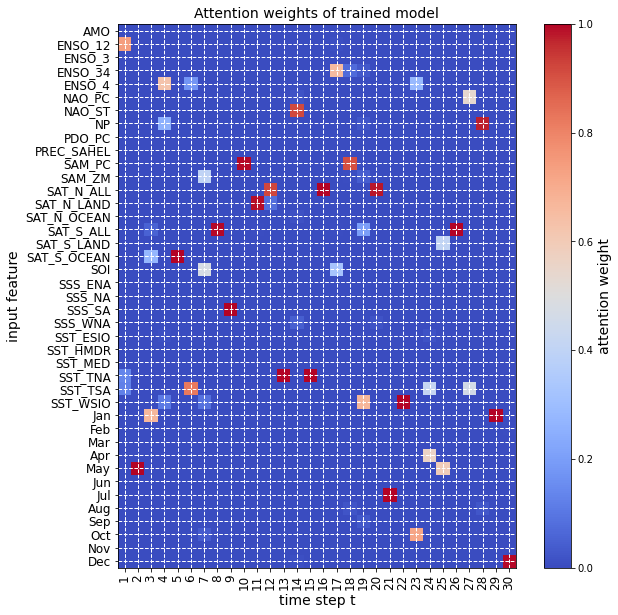

In [204]:
### Check, if the result is reproducible, have another trainings run:

# Show attention weights of trained model as heat map:
fig, ax = plt.subplots(figsize=(10, 10))
im = plt.imshow(attention_weights, cmap="coolwarm", interpolation='nearest')#, vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('attention weight', fontsize=14)
plt.title('Attention weights of trained model', fontsize=14)
plt.xlabel('time step t', fontsize=14)
plt.ylabel('input feature', fontsize=14)
plt.xticks(np.arange(0, input_length, step=1),np.arange(1, input_length+1, step=1), fontsize=12, rotation=90)
plt.yticks(np.arange(0, n_features, step=1), input_features_extended, fontsize=12)
ax.grid(color='white', linestyle='--', linewidth=1)
plt.show()

### Discussion: LSTM encoder/decoder - with 'naive' input attention - but: No softmaxing!

In our second to implement a **naive input attention**, we omitted softmaxing of initialized attention weights.
Resulting attention weights are only softmaxed afterwards for visualization.

Still, the results are not reproducible. But, however, the model learnes to encounter several input features per time step.